In [13]:
import sys
import os.path as op
    
import numpy as np
import pandas as pd
import mne

module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_analysis.functions_preprocessing import split_raws

# Create path to the folder "behavioral"
behav_dir = "/net/store/nbp/projects/hyperscanning/study_project/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"

# Create a list of path names that end with .csv
behav_path = op.join(behav_dir, "203.csv")#test


df = pd.read_csv(behav_path)


df.head()

,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first
0,203,blind,1,1,1,1,3.488252,0.075,1
1,203,blind,1,1,1,2,4.149057,0.075,1
2,203,blind,1,1,1,3,4.818118,0.075,1
3,203,blind,1,1,1,4,5.474000,0.075,1
4,203,blind,1,1,1,5,6.185978,0.075,1


In [14]:
def calculate_alpha(df):
    """
    Calculates the circular tapping synchrony measure as defined in Novembre et al. (2017).
    """

    # calculate the inter-person difference P(x) T(n) - P(y) T(n)
    # from both subjects' perspectives
    df.sort_values(['trial', 'tapnr'], inplace=True)
    df['diff_inter'] = df['ttap'].diff()
    df.iloc[::2, df.columns.get_loc('diff_inter')] = df['ttap'].diff(-1)

    # calculate the intra-person difference P(x) T(n + 1) - P(x) T(n)
    df['diff_intra'] = abs(df.groupby(['subject', 'trial'])['ttap'].diff(-1))  # .fillna(0)

    # calculate alpha and linearized alpha for all taps
    df['alpha'] = abs(df['diff_inter'] / df['diff_intra']) * 360
    df['alpha_lin'] = abs(180 - abs(df['alpha'] % 360 - 180))
    # TODO: discuss the linearization/ asynchronous trials. I found that there are single taps where the circular measure is larger than 360°
    # This means theoretically that the interperson diff is way bigger than the intra person diff, meaning that P1 made
    # the next tap already while P2 "misses" out one tap. By doing % 360, i define that these asynchronous trials are valid
    # and people can be synchronous, even if one tap was missed out by a person.
    # We could also instead remove these trials by removing the `% 360`, and cropping all df["alpha"] > 360 afterwards.
    
    return df


df = calculate_alpha(df)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    ddd = df[["subject", "trial", "tapnr", "diff_intra", "diff_inter", "alpha", "alpha_lin"]]
    print(ddd.sort_index())

      subject  trial  tapnr  diff_intra  diff_inter        alpha   alpha_lin
0           1      1      1    0.660805    0.108922    59.339627   59.339627
1           1      1      2    0.669061    0.055085    29.639412   29.639412
2           1      1      3    0.655882    0.066063    36.260705   36.260705
3           1      1      4    0.711978    0.072040    36.425888   36.425888
4           1      1      5    0.664024    0.111816    60.620893   60.620893
5           1      1      6    0.657998    0.120869    66.129240   66.129240
6           1      1      7    0.715177    0.141863    71.409775   71.409775
7           1      1      8    0.631029    0.197791   112.839022  112.839022
8           1      1      9         NaN    0.153093          NaN         NaN
9           2      1      1    0.714642   -0.108922    54.869318   54.869318
10          2      1      2    0.658083   -0.055085    30.133860   30.133860
11          2      1      3    0.649905   -0.066063    36.594180   36.594180

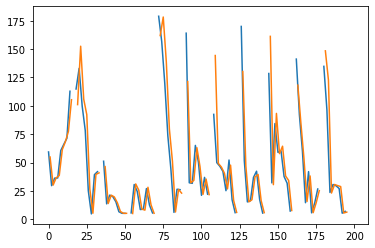

In [15]:

df.reset_index()["alpha_lin"].iloc[:200:2].plot()
df.reset_index()["alpha_lin"].iloc[1:200:2].plot()

In [16]:
def remove_outliers(df, exclude_stddev):
    """Remove all trials where the average alpha is `exclude_sttdev` sttdevs larger or
    smaller than the mean."""
    
    # calculate the mean alpha for each trial
    means = df.groupby(['trial'])["alpha"].mean()
    
    # define the upper and lower bounds, based on the mean and stddev of these means
    lower_bound = means.mean() - exclude_stddev * means.std()
    upper_bound = means.mean() + exclude_stddev * means.std()
    
    # filter the means so only the trials within the defined bounds remain
    good_trials = means[(lower_bound < means) & (means < upper_bound)]
    
    # return the df filtered for only the good trials
    return df[df["trial"].isin(good_trials.index)]


df = remove_outliers(df, 1)
df

,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first,diff_inter,diff_intra,alpha,alpha_lin
0,203,blind,1,1,1,1,3.488252,0.075,1,0.108922,0.660805,59.339627,59.339627
9,203,blind,1,1,2,1,3.379330,0.075,1,-0.108922,0.714642,54.869318,54.869318
1,203,blind,1,1,1,2,4.149057,0.075,1,0.055085,0.669061,29.639412,29.639412
10,203,blind,1,1,2,2,4.093972,0.075,1,-0.055085,0.658083,30.133860,30.133860
2,203,blind,1,1,1,3,4.818118,0.075,1,0.066063,0.655882,36.260705,36.260705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5397,203,blind,12,300,2,7,6.136573,0.075,1,-0.038842,0.500590,27.933260,27.933260
5389,203,blind,12,300,1,8,6.621934,0.075,1,-0.015229,0.943700,5.809510,5.809510
5398,203,blind,12,300,2,8,6.637163,0.075,1,0.015229,0.467523,11.726555,11.726555
5390,203,blind,12,300,1,9,7.565634,0.075,1,0.460948,NaN,NaN,NaN


In [17]:
subject_dir = '/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/'


pair = 202
participant = 0

# 1.2 define the subjects id and its path
subj_id = "sub-{0}_p-{1}".format(pair, participant)
subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(pair)
behav_path = op.join(behav_dir, str(pair) + ".csv")

# load the data
combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif...


<ipython-input-17-2f01f4ed25ef>:13: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Isotrak not found
    Range : 0 ... 3725311 =      0.000 ...  3637.999 secs
Ready.
Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg-1.fif...
Isotrak not found
    Range : 3725312 ... 5675445 =   3638.000 ...  5542.427 secs
Ready.
Reading 0 ... 5675445  =      0.000 ...  5542.427 secs...


In [18]:
EVENT_DICT = {'s1/t1':6, 's1/t2':7, 's1/t3':8, 's1/t4':9, 's1/t5':10, 's1/t6':11, 's1/t7':12, 's1/t8':13, 's1/t9':14,
              's2/t1':15, 's2/t2':16, 's2/t3':17, 's2/t4':18, 's2/t5':19, 's2/t6':20, 's2/t7':21, 's2/t8':22, 's2/t9':23}

INV_EVENT_DICT = {str(val): key for key, val in EVENT_DICT.items()}


EVENT_DICT

{'s1/t1': 6,
 's1/t2': 7,
 's1/t3': 8,
 's1/t4': 9,
 's1/t5': 10,
 's1/t6': 11,
 's1/t7': 12,
 's1/t8': 13,
 's1/t9': 14,
 's2/t1': 15,
 's2/t2': 16,
 's2/t3': 17,
 's2/t4': 18,
 's2/t5': 19,
 's2/t6': 20,
 's2/t7': 21,
 's2/t8': 22,
 's2/t9': 23}

In [19]:
# 2.2. Look for events in raw
#raw.info

events = mne.find_events(combined_raw, shortest_event=1)
events

6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]


array([[ 191183,       0,       1],
       [ 191252,       0,       2],
       [ 202497,       0,       2],
       ...,
       [5636326,       0,      23],
       [5636336,       0,      49],
       [5638973,       0,      46]])

In [20]:
def remove_ghost_triggers(df):
    """Removes Ghost Triggers from an event dataframe, based on the logic that
    all taps from each person should have a larger code than the previous tap
    from the same person."""
    
    # split the tap dataframe up for each subject
    for subj in [1,2]:
        subj_df = df[df['event_name'].str.startswith("s" + str(subj))]
        subj_df.sort_values(['sample'])
    
    
        # look only at the indices and event codes from one person
        indices = subj_df["event_index"].to_numpy()
        event_codes = subj_df["event_code"].to_numpy()
    
        for i in range(len(indices)):
        
            # look at the previous code, current code and the current index
            previous_code = event_codes[i-1]
            current_code = event_codes[i]
            current_index = indices[i]
        
            # the initial tap codes are allowed to be smaller than the previous taps
            if current_code not in (6, 15):
            
                # for all other taps, if the code is not one step higher than the
                # previous trigger, it's a ghost trigger.
                if current_code != previous_code + 1:
                
                    # then we remove the ghost trigger from the orginial dataframe
                    df = df[df["event_index"] != current_index]
                    
                    # replace the ghost trigger value in event codes, so the next
                    # iteration will reference the last valid trigger.
                    event_codes[i] = event_codes[i-1]
                
    return df


In [21]:
def create_event_df(raw):
    """Reads events, assigns them event names and creates an event dataframe."""
    
    events = mne.find_events(raw, shortest_event=1)

    # create a pandas DataFrame to make working with events easier
    df_events = pd.DataFrame(events[:, (0, 2)])
    df_events.columns = ('sample','event_code')
    df_events['event_index'] = range(len(df_events))
    
    # add the trial number to later match the df with the behavioral data
    df_events['event_trial'] = 0
    
    # each time we see the "trial start" trigger, we increase the trial number
    for idx, row in df_events.iterrows():
        if row['event_code'] == 48:
            df_events['event_trial'][idx:] += 1

    # filter out the tapping events only
    df_events = df_events[df_events['event_code'].isin(EVENT_DICT.values())]

    # create a column including the event names
    df_events['event_name'] = [INV_EVENT_DICT[str(code)] for code in df_events['event_code']]
    
    return df_events


def events_from_event_df(df):
    """Sort a combined event dataframe and return it to a mne-style numpy array."""
    df.sort_values(['event_index'])
    events = np.vstack([df['sample'],
                        np.zeros(len(df)),
                        df['event_code']]).astype(int).T
    
    return events


def join_event_dfs(event_df, behavioral_df):
    """Join a behavioral and an event dataframe."""
    
    # sort both dataframes after trial, subject, tap
    event_df.sort_values(['event_trial', 'event_name'])
    behavioral_df.sort_values(['trial', 'subject', 'tapnr'])
    
    # reset the event df index to the behavioral df
    event_df.index = behavioral_df.index
    
    return event_df.join(behavioral_df).drop(columns=['event_trial'])

In [22]:
event_df = create_event_df(combined_raw)
ghost_events = event_df['event_code'].value_counts()
ghost_events

6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]


20    301
23    300
19    300
12    300
16    300
9     300
13    300
17    300
21    300
6     300
10    300
14    300
18    300
22    300
7     300
11    300
15    300
8     300
Name: event_code, dtype: int64

In [23]:
event_df = create_event_df(combined_raw)
event_df = remove_ghost_triggers(event_df)
behavioral_df = calculate_alpha(pd.read_csv(behav_path))

joint_df = join_event_dfs(event_df, behavioral_df)

clean_df = remove_outliers(joint_df, exclude_stddev=2)

events = events_from_event_df(joint_df)

print(events)
clean_df.sort_index()

6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]
[[ 274640       0       6]
 [ 274892       0      15]
 [ 275557       0       7]
 ...
 [5635492       0      22]
 [5636230       0      14]
 [5636326       0      23]]


,sample,event_code,event_index,event_name,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first,diff_inter,diff_intra,alpha,alpha_lin
0,274640,6,16,s1/t1,202,blind,1,1,1,1,3.216545,0.025,1,-0.246290,0.895074,99.058151,99.058151
1,275557,7,18,s1/t2,202,blind,1,1,1,2,4.111619,0.025,1,-0.045056,0.802895,20.202038,20.202038
2,276379,8,20,s1/t3,202,blind,1,1,1,3,4.914514,0.025,1,-0.035124,0.791843,15.968645,15.968645
3,277190,9,22,s1/t4,202,blind,1,1,1,4,5.706357,0.025,1,-0.010081,0.824135,4.403519,4.403519
4,278014,19,24,s2/t5,202,blind,1,1,1,5,6.530492,0.025,1,0.018826,0.725878,9.336779,9.336779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,5633054,19,6637,s2/t5,202,blind,12,300,2,5,7.135232,0.075,2,0.023280,0.876054,9.566494,9.566494
5396,5633951,20,6639,s2/t6,202,blind,12,300,2,6,8.011286,0.075,2,0.110098,0.725927,54.599474,54.599474
5397,5634694,21,6641,s2/t7,202,blind,12,300,2,7,8.737213,0.075,2,0.069454,0.778894,32.101191,32.101191
5398,5635492,22,6643,s2/t8,202,blind,12,300,2,8,9.516107,0.075,2,0.037360,0.814203,16.518709,16.518709


In [24]:
int(5635492 + (10.330310 - 9.516107) * 1024) # should be equal to 5636326

5636325